In [2]:
import json

from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredictVGGish
import numpy as np
import matplotlib.pyplot as plt


In [5]:
audio_file = 'sample/ambienceTrack_001(1).mp3'
audio = MonoLoader(sampleRate=16000, filename=audio_file)()
audio.shape

(14529097,)

## Key/Scale

In [23]:
from essentia.standard import KeyExtractor

KeyExtractor()(audio)

('D', 'major', 0.9219905138015747)

## Mood/Genre/Theme Tagging

In [30]:
metadata = json.load(open('weights/msd-musicnn-1.json', 'r'))
model = TensorflowPredictMusiCNN(graphFilename='weights/msd-musicnn-1.pb')

audio = MonoLoader(filename="audio.wav", sampleRate=16000, resampleQuality=4)()
logits = model(audio)
logits.shape

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/msd-musicnn-1.pb`


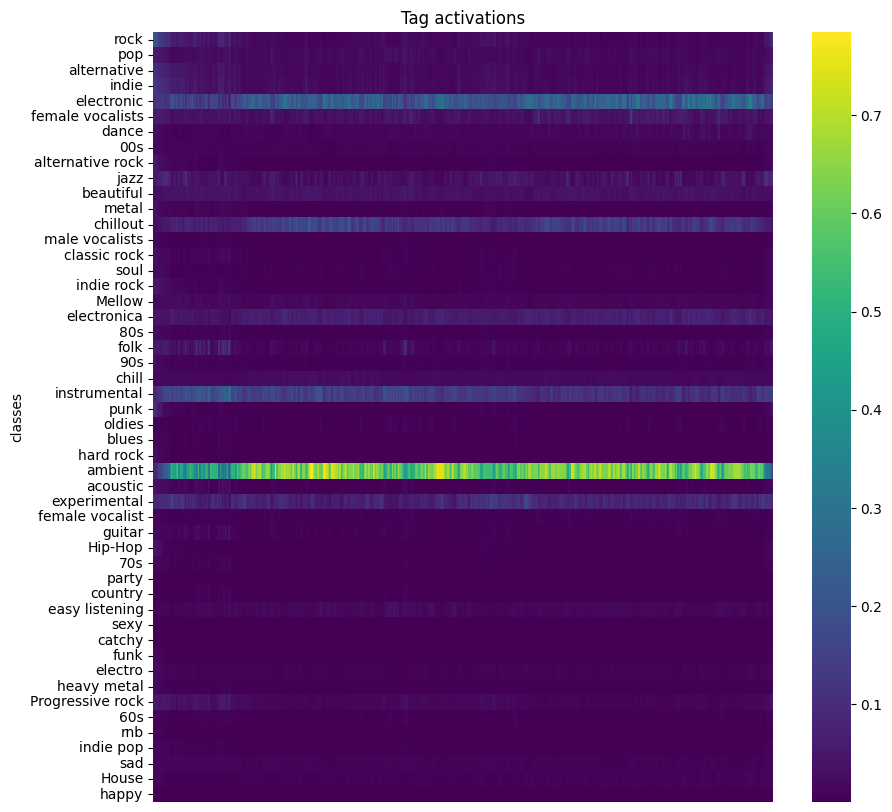

In [19]:
import seaborn as sns

# Assuming 'activations' is your matrix and 'metadata['classes']' are the labels for the rows
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    logits.T, annot=False, cmap='viridis', cbar=True, yticklabels=metadata['classes'], xticklabels=False
)
ax.set_ylabel('classes')
ax.set_title('Tag activations')

# Move x-axis to bottom
ax.xaxis.tick_bottom()

plt.show()

## Genre and Instrumentation

In [10]:
from essentia.standard import TensorflowPredictEffnetDiscogs, TensorflowPredict2D

effnet_embedding_model = TensorflowPredictEffnetDiscogs(
    graphFilename="weights/discogs-effnet-bs64-1.pb", 
    output="PartitionedCall:1"
)

genre_classes = json.load(open('weights/mtg_jamendo_genre-discogs-effnet-1.json', 'r'))['classes']
genre_head = TensorflowPredict2D(graphFilename="weights/mtg_jamendo_genre-discogs-effnet-1.pb")
inst_classes = json.load(open('weights/mtg_jamendo_instrument-discogs-effnet-1.json', 'r'))['classes']
inst_head = TensorflowPredict2D(graphFilename="weights/mtg_jamendo_instrument-discogs-effnet-1.pb")

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/mtg_jamendo_instrument-discogs-effnet-1.pb`


In [9]:
emb = effnet_embedding_model(audio)
genre_preds = genre_head(emb)
inst_preds = inst_head(emb)
emb.shape, genre_preds.shape, inst_preds.shape

2024-06-24 21:05:33.222682: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/mtg_jamendo_instrument-discogs-effnet-1.pb`


((914, 1280), (914, 87), (914, 40))

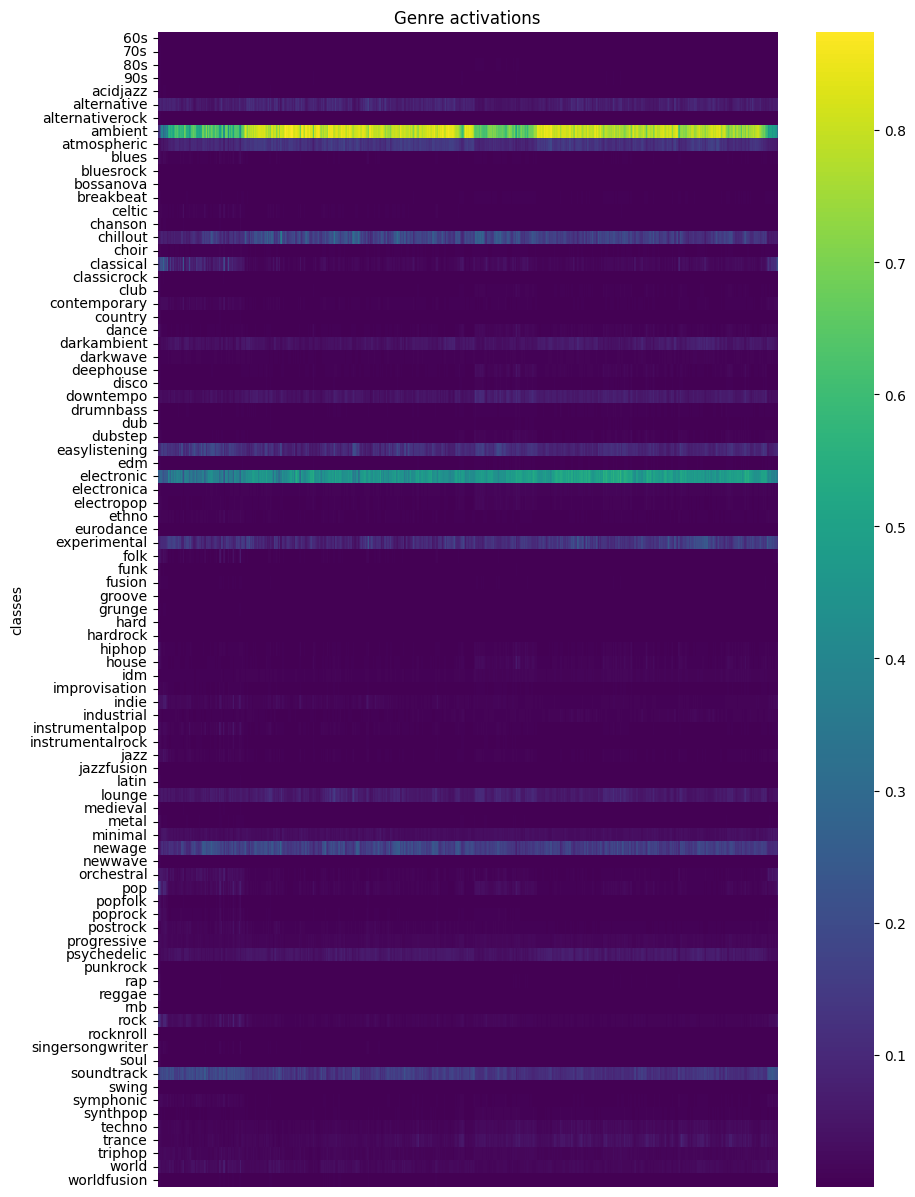

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 15))
ax = sns.heatmap(
    genre_preds.T, annot=False, cmap='viridis', cbar=True, yticklabels=genre_classes, xticklabels=False
)
ax.set_ylabel('classes')
ax.set_title('Genre activations')

# Move x-axis to bottom
ax.xaxis.tick_bottom()

plt.show()

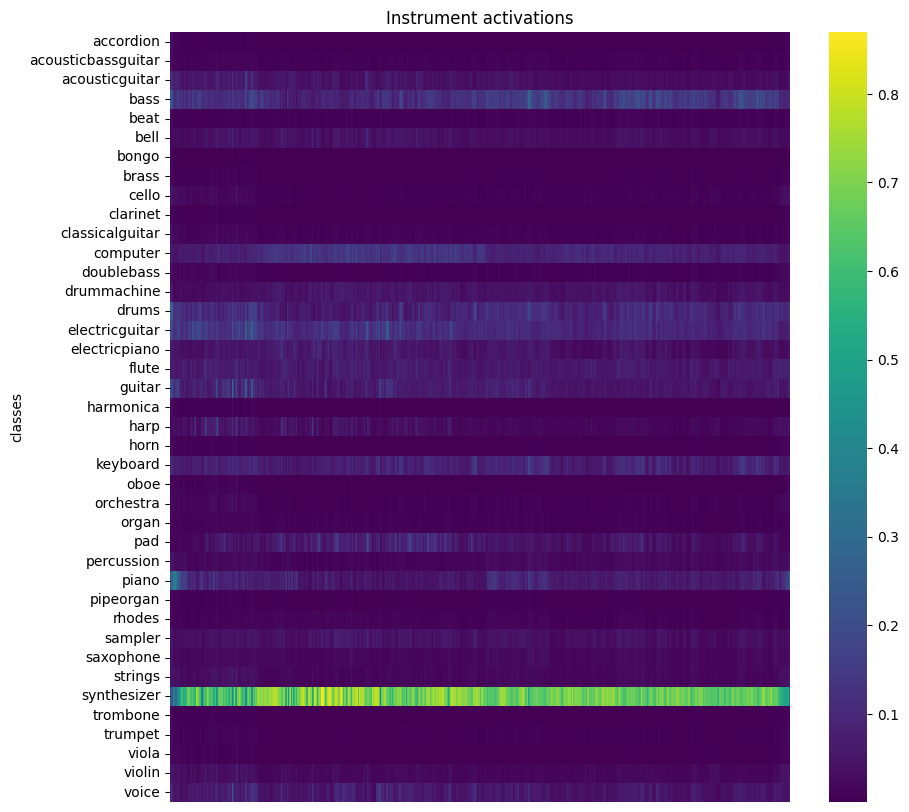

In [15]:
import seaborn as sns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    inst_preds.T, annot=False, cmap='viridis', cbar=True, yticklabels=inst_classes, xticklabels=False
)
ax.set_ylabel('classes')
ax.set_title('Instrument activations')

# Move x-axis to bottom
ax.xaxis.tick_bottom()

plt.show()

## Emotion Recognition

In [31]:
embedding_model = TensorflowPredictMusiCNN(graphFilename="weights/msd-musicnn-1.pb", output="model/dense/BiasAdd")
emo_head = TensorflowPredict2D(graphFilename="weights/emomusic-msd-musicnn-2.pb", output="model/Identity")

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `weights/emomusic-msd-musicnn-2.pb`


In [35]:
# embeddings = embedding_model(audio)
predictions = emo_head(embeddings)
predictions.shape, embeddings.shape

((609, 2), (609, 200))

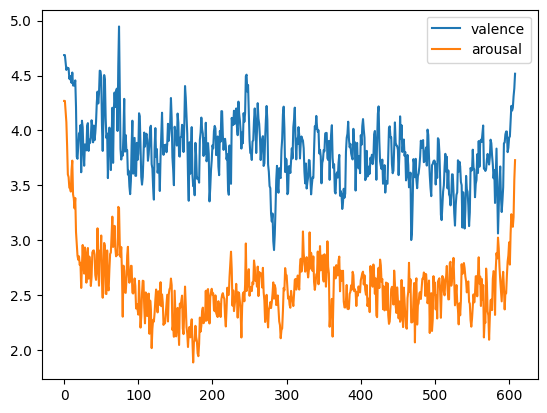

In [38]:
plt.plot(predictions[:, 0], label='valence')
plt.plot(predictions[:, 1], label='arousal')
plt.legend()